## Imports

In [16]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd
import seaborn as sns

## Preprocessing

In [5]:
DATASET_PATH = '../COGS 118C Project/data/'
SUBJECTS = ["S001", "S002", "S003", "S004", "S005"]  
TASK_RUNS = ["R03", "R04", "R07", "R08", "R11", "R12"] 

SFREQ = 160  
LOW_CUT = 1.0 
HIGH_CUT = 40.0  
NOTCH_FREQ = 60 
WINDOW_SIZE = 2 
WINDOW_SAMPLES = int(WINDOW_SIZE * SFREQ)  

In [6]:
def load_eeg_data(subject, run):
    edf_file = os.path.join(DATASET_PATH, subject, f"{subject}{run}.edf")

    if not os.path.exists(edf_file):
        print(f"Error: Missing {edf_file}")
        return None, None, None

    try:
        raw = mne.io.read_raw_edf(edf_file, preload=True)
        raw.pick(["C3..", "Cz..", "C4.."])

        events, event_dict = mne.events_from_annotations(raw) 
        event_dict = {str(k): v for k, v in event_dict.items()}  

        event_mapping = {"T1": 1, "T2": 2}  
        filtered_events = []

        for event in events:
            event_desc = list(event_dict.keys())[list(event_dict.values()).index(event[2])]
            if event_desc in event_mapping:
                event[2] = event_mapping[event_desc]  
                filtered_events.append(event)

        events = np.array(filtered_events)  

    except Exception as e:
        print(f"Error loading {edf_file}: {e}")
        return None, None, None

    return raw, events, event_dict 

In [7]:
def preprocess_eeg(raw):
    
    raw.filter(LOW_CUT, HIGH_CUT, fir_design='firwin')
    raw.notch_filter(NOTCH_FREQ, fir_design='firwin')
    raw.set_eeg_reference('average', projection=True)

    return raw

In [8]:
def segment_eeg(raw, events, run):
    segmented_data = []
    labels = []
    run_type = "real" if run in ["R03", "R07", "R11"] else "imagined"

    for event in events:
        onset_sample = event[0]
        event_type = event[2]

        if event_type == 0: 
            continue

        start = onset_sample
        end = start + WINDOW_SAMPLES

        if end >= len(raw.times): 
            continue

        segment = raw.get_data(start=start, stop=end)
        segmented_data.append(segment)
        labels.append(run_type)

    return np.array(segmented_data), np.array(labels)

In [9]:
def extract_psd_features(eeg_data, sfreq=SFREQ):
    psd_features = []
    for trial in eeg_data:
        trial_psd = []
        for channel in range(trial.shape[0]):
            freqs, psd = welch(trial[channel, :], fs=sfreq, nperseg=sfreq//2)
            trial_psd.extend(psd) 
        psd_features.append(trial_psd)

    return np.array(psd_features)

In [10]:
def plot_raw_vs_filtered(raw, filtered, subject, run):
    plt.figure(figsize=(12, 6))
    
    for i, ch in enumerate(["C3..", "Cz..", "C4.."]):
        plt.subplot(3, 1, i+1)
        plt.plot(raw.get_data()[i, :], label="Raw", alpha=0.5)
        plt.plot(filtered.get_data()[i, :], label="Filtered", alpha=0.9)
        plt.title(f"{subject} {run} - {ch} Channel")
        plt.legend()

    plt.xlabel("Time Points")
    plt.tight_layout()
    plt.show()

In [11]:
def plot_psd(raw, subject, run):
    plt.figure(figsize=(8, 5))
    raw.plot_psd(fmin=0.5, fmax=50, show=False)
    plt.title(f"PSD - {subject} {run}")
    plt.tight_layout()
    plt.show()

In [12]:
def process_all_data():
    all_features = []
    all_labels = []
    
    for subject in SUBJECTS:
        for run in TASK_RUNS:
            print(f"Processing {subject} {run}...")
            
            raw, events, events_dict = load_eeg_data(subject, run)
            if raw is None or events is None:
                continue
                
            raw = preprocess_eeg(raw)
            segmented_data, labels = segment_eeg(raw, events, run)
            psd_features = extract_psd_features(segmented_data)
            
            all_features.append(psd_features)
            all_labels.extend(labels)
    
    X = np.vstack(all_features)
    y = np.array(all_labels)
    
    y = np.where(y == "real", 1, 0)
    
    print(f"Processed data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Label distribution: {np.bincount(y)}")
    
    return X, y

In [13]:
all_features = []
all_labels = []

for subject in SUBJECTS:
    for run in TASK_RUNS:
        print(f"Processing {subject} {run}...")
        
        raw, events, events_dict = load_eeg_data(subject, run)
        if raw is None or events is None:
            continue
            
        raw = preprocess_eeg(raw)
        segmented_data, labels = segment_eeg(raw, events, run)
        psd_features = extract_psd_features(segmented_data)
        
        all_features.append(psd_features)
        all_labels.extend(labels)

X_processed = np.vstack(all_features)
y_processed = np.array(all_labels)

y_processed = np.where(y_processed == "real", 1, 0)

print(f"Processed data shape: {X_processed.shape}")
print(f"Labels shape: {y_processed.shape}")
print(f"Label distribution: {np.bincount(y_processed)}")

Processing S001 R03...
Extracting EDF parameters from /Users/ananyakrishnan/Downloads/COGS 118C Project/data/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR fi

## Plots

Extracting EDF parameters from /Users/ananyakrishnan/Downloads/COGS 118C Project/data/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
-------

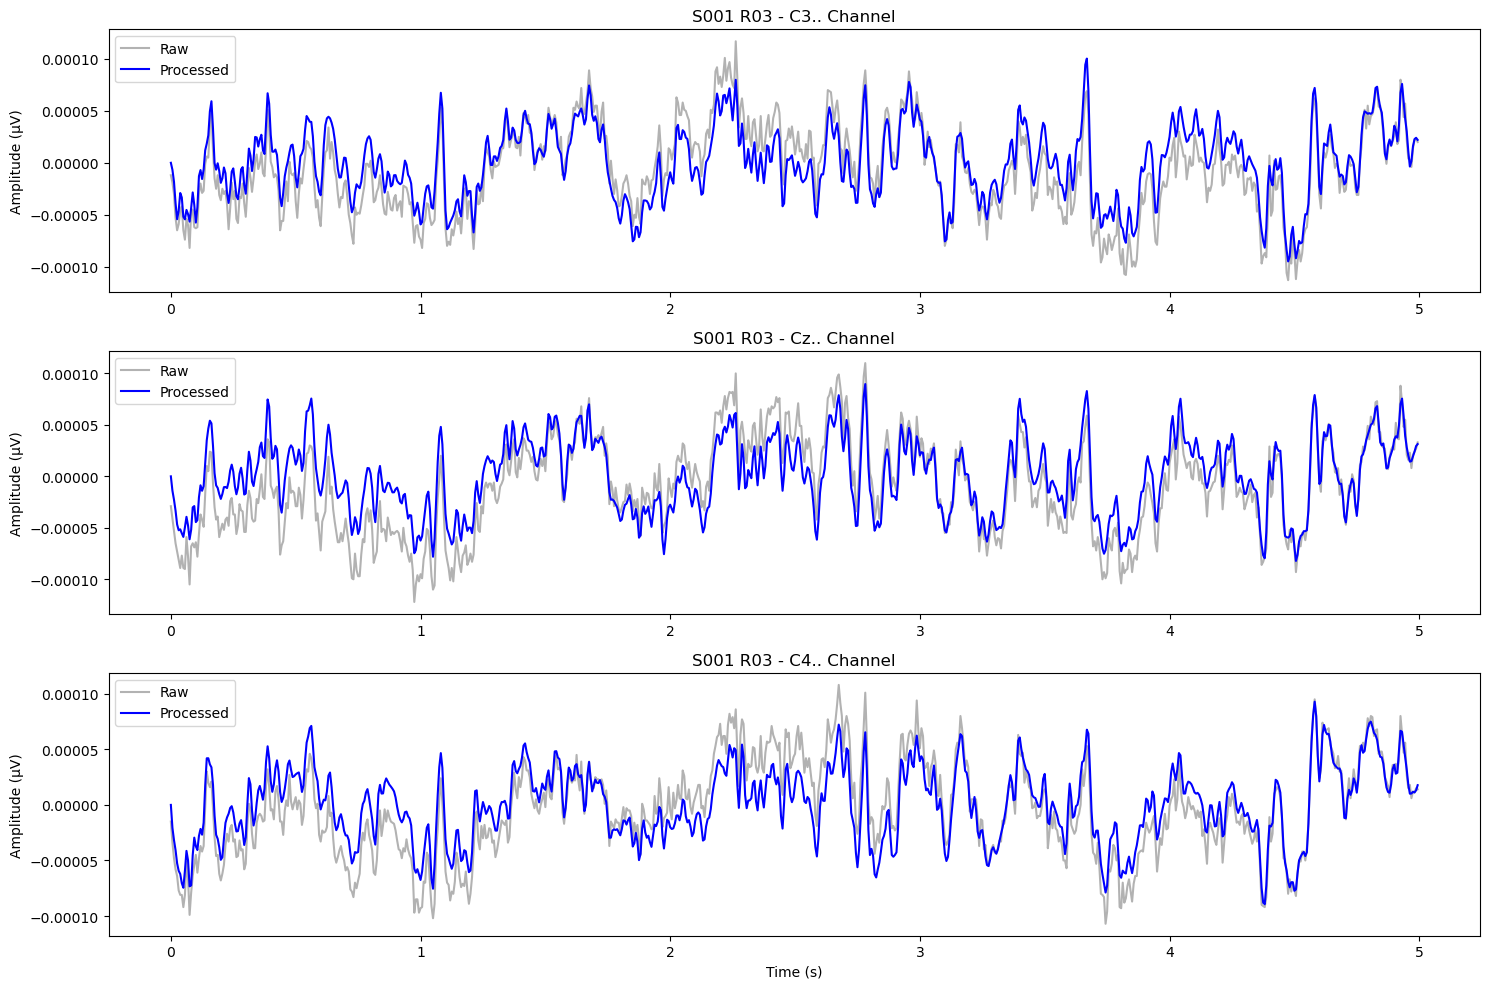

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/var/folders/fs/b6n1rrm11k96n9qwk9cl0gc00000gn/T/ipykernel_34418/1026786229.py:33: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=0.5, fmax=50, show=False)
/var/folders/fs/b6n1rrm11k96n9qwk9cl0gc00000gn/T/ipykernel_34418/1026786229.py:37: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered.plot_psd(fmin=0.5, fmax=50, show=False)
/var/folders/fs/b6n1rrm11k96n9qwk9cl0gc00000gn/T/ipykernel_34418/1026786229.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


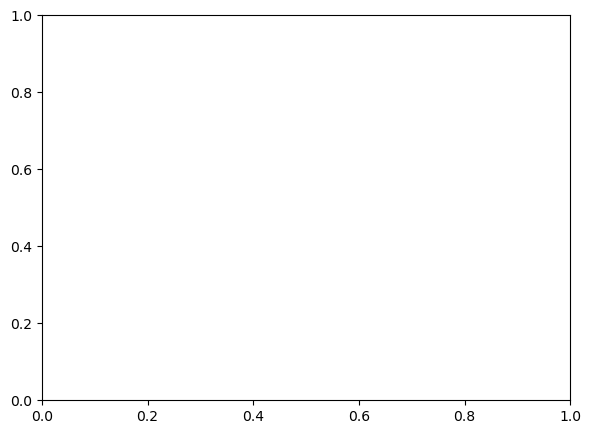

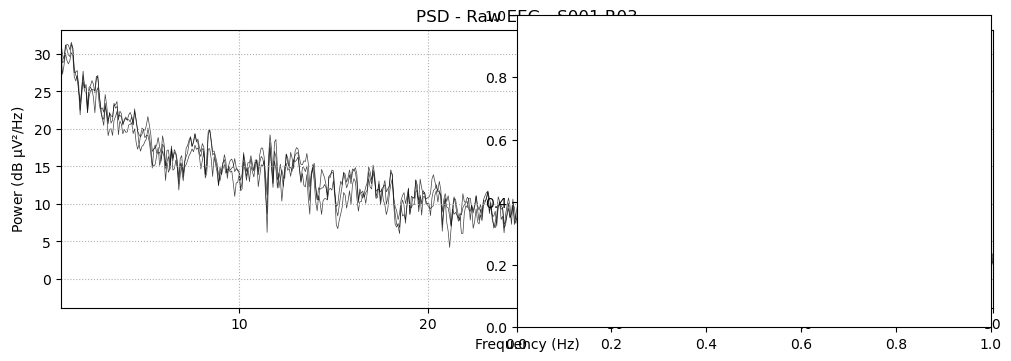

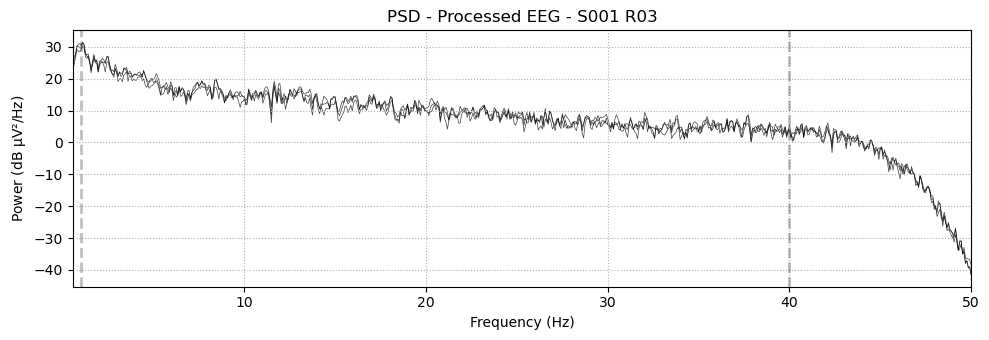

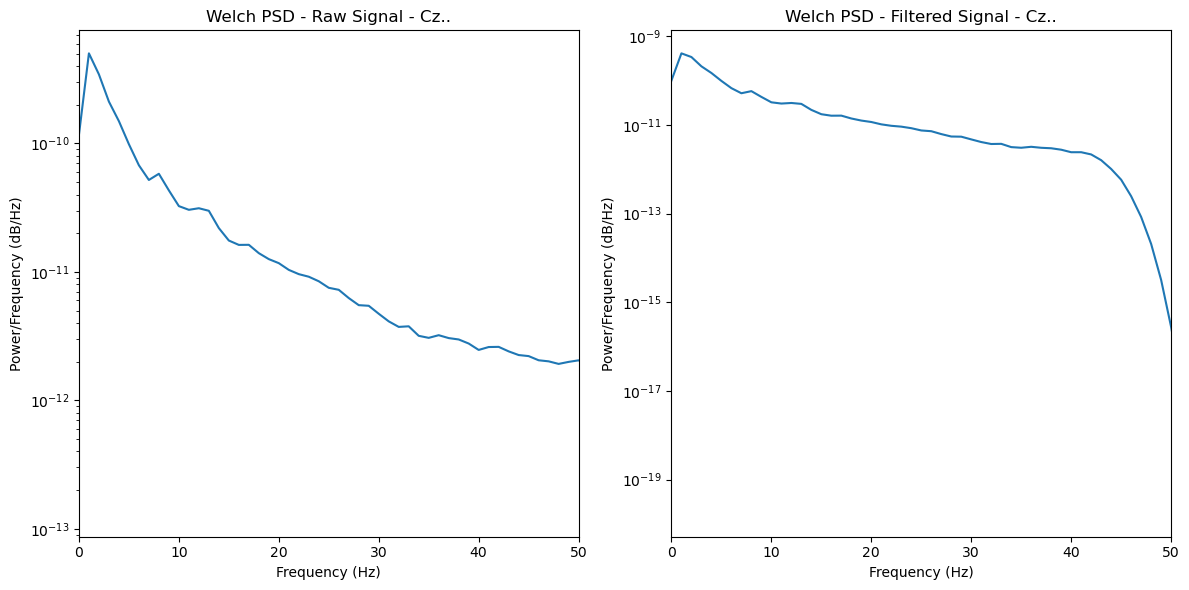

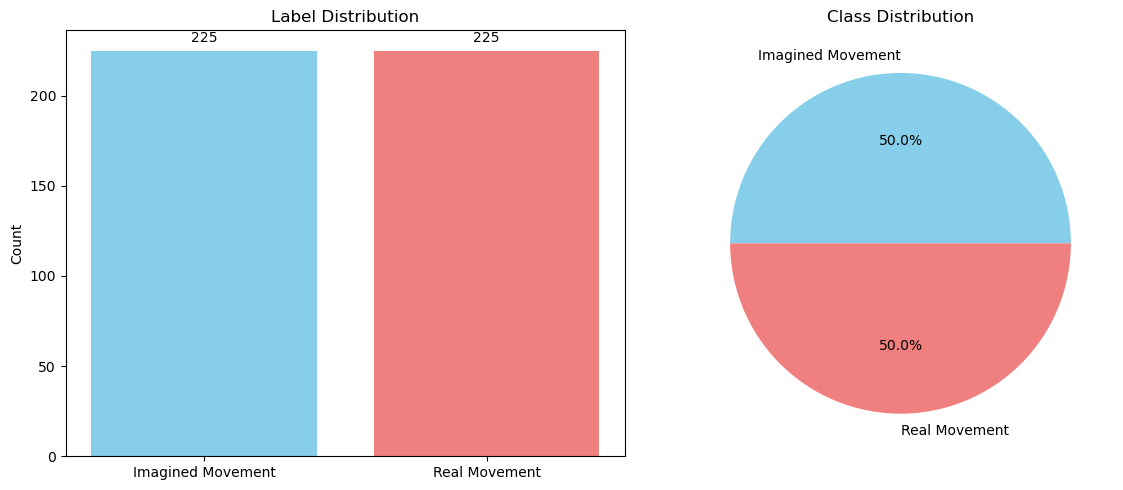

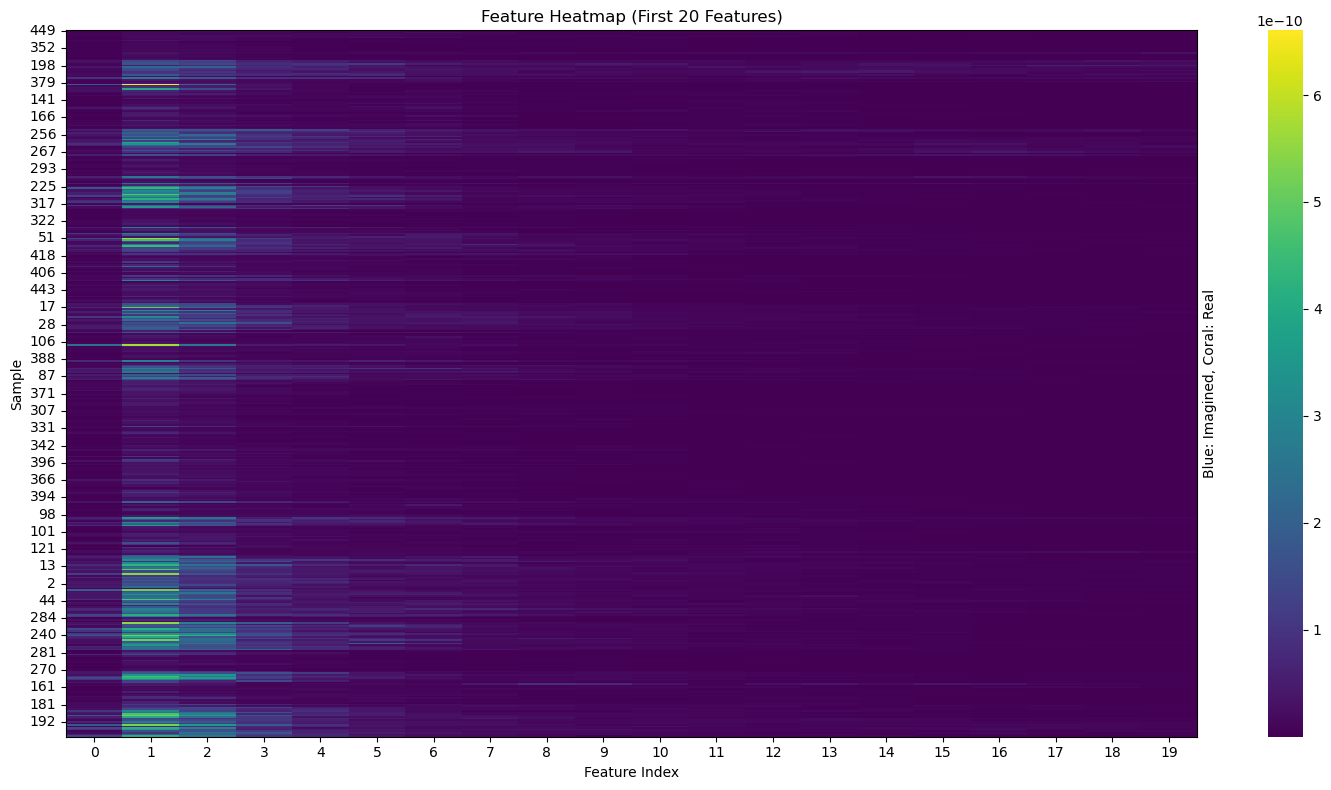

In [17]:
# 1. Plot raw vs processed EEG signals
subject = "S001"
run = "R03"
raw, _, _ = load_eeg_data(subject, run)

if raw is not None:
    filtered = preprocess_eeg(raw.copy())
    
    plt.figure(figsize=(15, 10))
    channels = ["C3..", "Cz..", "C4.."]
    duration = 5  
    samples = int(duration * raw.info['sfreq'])
    time = np.arange(samples) / raw.info['sfreq']
    
    for i, ch in enumerate(channels):
        ch_idx = raw.ch_names.index(ch)
        
        plt.subplot(3, 1, i+1)
        plt.plot(time, raw.get_data()[ch_idx, :samples], label='Raw', alpha=0.6, color='gray')
        plt.plot(time, filtered.get_data()[ch_idx, :samples], label='Processed', color='blue')
        plt.title(f"{subject} {run} - {ch} Channel")
        plt.ylabel('Amplitude (μV)')
        plt.legend()
    
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

    # 2. Plot PSD comparison
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    raw.plot_psd(fmin=0.5, fmax=50, show=False)
    plt.title(f"PSD - Raw EEG - {subject} {run}")
    
    plt.subplot(1, 2, 2)
    filtered.plot_psd(fmin=0.5, fmax=50, show=False)
    plt.title(f"PSD - Processed EEG - {subject} {run}")
    
    plt.tight_layout()
    plt.show()

    # 3. Plot Welch PSD for a specific channel
    channel = "Cz.."
    ch_idx = raw.ch_names.index(channel)
    fs = raw.info['sfreq']
    
    # Get data
    raw_signal = raw.get_data()[ch_idx, :]
    filtered_signal = filtered.get_data()[ch_idx, :]
    
    # Compute Welch's PSD
    f_raw, psd_raw = welch(raw_signal, fs=fs, nperseg=fs)
    f_filtered, psd_filtered = welch(filtered_signal, fs=fs, nperseg=fs)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.semilogy(f_raw, psd_raw)
    plt.title(f"Welch PSD - Raw Signal - {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.xlim(0, 50)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(f_filtered, psd_filtered)
    plt.title(f"Welch PSD - Filtered Signal - {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.xlim(0, 50)
    
    plt.tight_layout()
    plt.show()

# 4. Plot label distribution
class_names = ['Imagined Movement', 'Real Movement']
counts = np.bincount(y_processed)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(class_names, counts, color=['skyblue', 'lightcoral'])
plt.ylabel('Count')
plt.title('Label Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 5, str(v), ha='center')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=class_names, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution')

plt.tight_layout()
plt.show()

# 5. Feature heatmap visualization
# Select a subset of features for visibility
n_features = 20
X_subset = X_processed[:, :n_features]

# Create a DataFrame for easier plotting


df = pd.DataFrame(X_subset)
df['label'] = y_processed
df['label'] = df['label'].map({0: 'Imagined', 1: 'Real'})

# Sort by label
df = df.sort_values('label')

# Split label column
labels = df['label']
df = df.drop('label', axis=1)

plt.figure(figsize=(15, 8))

# Plot heatmap
sns.heatmap(df, cmap='viridis')
plt.title(f'Feature Heatmap (First {n_features} Features)')
plt.xlabel('Feature Index')
plt.ylabel('Sample')

# Add colored bar for labels
ax2 = plt.gca().twinx()
ax2.set_ylim(plt.gca().get_ylim())
y_ticks = np.arange(len(labels))
colors = ['skyblue' if l == 'Imagined' else 'lightcoral' for l in labels]
ax2.scatter([-0.5] * len(y_ticks), y_ticks, c=colors, s=10, marker='s')
ax2.set_yticks([])
ax2.set_ylabel('Blue: Imagined, Coral: Real')

plt.tight_layout()
plt.show()